In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
data = pd.read_csv('/content/TwitterSentiments.csv')
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [7]:
data.drop(['id'], axis=1, inplace=True)
data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [9]:
data['label'].value_counts()

,count
label,
0,29720
1,2242


<Axes: xlabel='label', ylabel='count'>

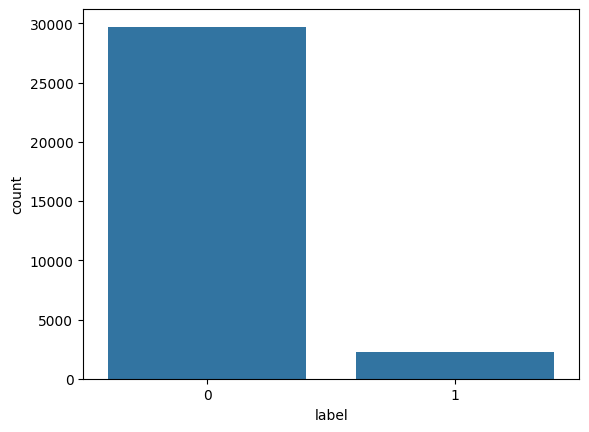

In [11]:
sns.countplot(x= data['label'])

In [13]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Print the original class distribution
print("Original class distribution:", Counter(data['label']))
over_sampler = RandomOverSampler(random_state=42)
X_resampled, Y_resampled = over_sampler.fit_resample(np.array(data['tweet']).reshape(-1, 1), data['label'])
print("Resampled class distribution:", Counter(Y_resampled))

# Convert resampled features back to list of strings
X_resampled = X_resampled.ravel()

Original class distribution: Counter({0: 29720, 1: 2242})
Resampled class distribution: Counter({0: 29720, 1: 29720})


<Axes: xlabel='label', ylabel='count'>

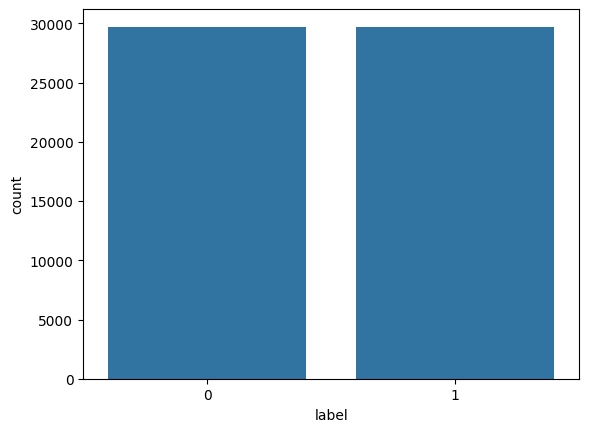

In [14]:
sns.countplot(x= Y_resampled)

In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
st = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
import re
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
def clean(tweet):
    tweet = re.sub('[^A-z]',' ',tweet)
    tweet = tweet.lower()
    tweet = tweet.split()
    tweet = [word for word in tweet if word not in st]
    tweet = ' '.join(tweet)
    tweet = lemmatizer.lemmatize(tweet)
    return tweet


In [20]:
data['tweet'] = data['tweet'].apply(clean)

In [21]:
data

,label,tweet
0,0,user father dysfunctional selfish drags kids d...
1,0,user user thanks lyft credit use cause offer w...
2,0,bihday majesty
3,0,model love u take u time ur
4,0,factsguide society motivation
...,...,...
31957,0,ate user isz youuu
31958,0,see nina turner airwaves trying wrap mantle ge...
31959,0,listening sad songs monday morning otw work sad
31960,1,user sikh temple vandalised calgary wso condem...


In [22]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [23]:
X = data['tweet'].values
y = data['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Tokenizer settings
MAX_NB_WORDS = 10000  # The maximum number of words to consider
MAX_SEQUENCE_LENGTH = 50  # Maximum length of each tweet (padding or truncating)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Padding sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH)

# Convert labels to categorical (if you're using more than 2 classes, otherwise binary)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Build the LSTM model without GlobalMaxPooling1D
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=100, input_length=MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# LSTM layer
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

# Dense output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_pad, y_val))


Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 91s 103ms/step - accuracy: 0.9302 - loss: 0.2338 - val_accuracy: 0.9568 - val_loss: 0.1293
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 132s 97ms/step - accuracy: 0.9690 - loss: 0.0925 - val_accuracy: 0.9600 - val_loss: 0.1287
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 79s 98ms/step - accuracy: 0.9797 - loss: 0.0637 - val_accuracy: 0.9618 - val_loss: 0.1167
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 77s 96ms/step - accuracy: 0.9835 - loss: 0.0510 - val_accuracy: 0.9607 - val_loss: 0.1392
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 84s 98ms/step - accuracy: 0.9872 - loss: 0.0389 - val_accuracy: 0.9567 - val_loss: 0.1590
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 81s 97ms/step - accuracy: 0.9909 - loss: 0.0286 - val_accuracy: 0.9582 - val_loss: 0.1580
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 82s 97ms/step - accuracy: 0.9916 - loss: 0.0263 - val_accuracy: 0.9585 - val_loss: 0.1800
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 83s 98ms/step - accuracy: 0.9949 - loss: 0.0178 

In [28]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

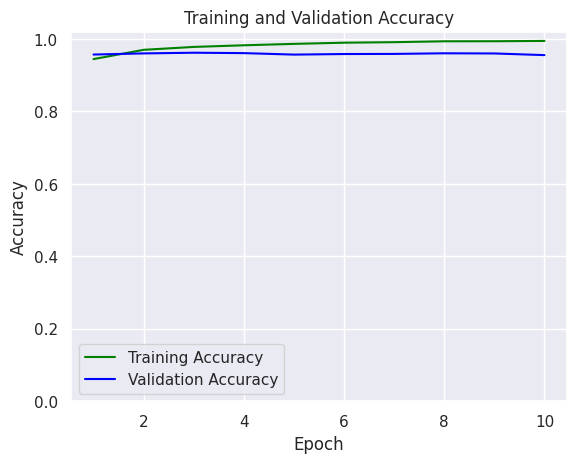

In [30]:
#accuracy plot
import matplotlib.pyplot as plt
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0,1.02)
plt.show()

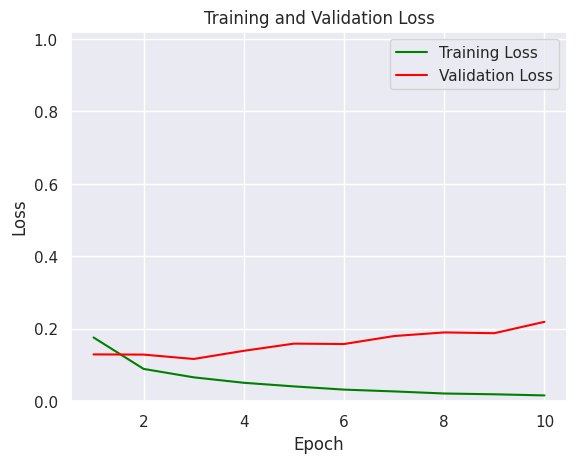

In [31]:
plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,1.02)
plt.show()

In [33]:
# Evaluate the model
model_evaluate = model.evaluate(X_val_pad, y_val )
print("Loss     : ",model_evaluate[0])
print("Accuracy : ",model_evaluate[1])

200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9563 - loss: 0.1990
Loss     :  0.21918229758739471
Accuracy :  0.9552635550498962


In [46]:
# Example new tweet
new_tweet = ['user sikh temple vandalised calgary wso condemns act']

# Preprocess the new tweet
# new_tweet_processed = clean(new_tweet[0])

# Tokenize and pad the new tweet
new_tweet_seq = tokenizer.texts_to_sequences([new_tweet])
new_tweet_pad = pad_sequences(new_tweet_seq, maxlen=MAX_SEQUENCE_LENGTH)

# Predict sentiment
prediction = model.predict(new_tweet_pad)
print("Positive" if prediction[0] > 0.5 else "Negative")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Negative
